## Calculating SCSS for PEC and RAW PEC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PySulfSat as ss
import Thermobar as pt

In [2]:
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = 'arial'
plt.rcParams["font.size"] =12
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["xtick.labelsize"] = 12 # Sets size of numbers on tick marks
plt.rcParams["axes.titlesize"] = 14 # Overall title
plt.rcParams["axes.labelsize"] = 14 # Axes labels

## Loading 2018 melt inclusion data

In [3]:
# Loading 2018 melt inclusion data
All2018_MI_preS=pd.read_excel(r'../Spreadsheets/Supporting_Information_2.xlsx', sheet_name="Wieser_Ol_Hosted_MI_2018")


F8_MI_with_sulf=All2018_MI_preS.loc[All2018_MI_preS['S_Sulf']>0]

MC1_all, all_outputs=ss.propagate_s_in_sulfide(sample_ID=F8_MI_with_sulf['Comment'], N_dup=1000, S_Sulf=32,
            Vol=F8_MI_with_sulf['Vol_Prop_Sulf'],
sulf_dens=4350, melt_dens=1000*F8_MI_with_sulf['Density_g_per_cm3'],
error_type_melt_dens='Abs', error_dist_melt_dens='normal', error_melt_dens=1000*All2018_MI_preS['Uncertainty_g_per_cm3'],
error_S_Sulf=3, error_type_S_Sulf='Abs', error_dist_S_Sulf='uniform',
error_Vol=50, error_type_Vol='Perc', error_dist_Vol='normal',
error_sulf_dens=150, error_type_sulf_dens='Abs', error_dist_sulf_dens='uniform',                       
plot_figure=True, len_loop=1)
MC1_all.head()
MC1_all['Comment']=MC1_all['Filename']
All2018_MI=pd.merge(All2018_MI_preS, MC1_all, on='Comment', how='left')
All2018_MI.head()


JustF8_MI=(All2018_MI['Sample number']=="LL4")|(All2018_MI['Sample number']=="LL7")|(All2018_MI['Sample number']=="LL8")
F8_MI=All2018_MI.loc[JustF8_MI].reset_index(drop=True)
LL4_MI=F8_MI['Sample number']=="LL4"
LL7_MI=F8_MI['Sample number']=="LL7"
LL8_MI=F8_MI['Sample number']=="LL8"

F8_MI_with_sulf=F8_MI.loc[F8_MI['ind_s_eq_melt']>0]

# Loading 2018 matrix glass
All2018_MG=pd.read_excel(r'../Spreadsheets/Supporting_Information_2.xlsx', sheet_name="Wieser_MatrixGlass_2018")
JustF8_MG=(All2018_MG['Sample number']=="LL4")|(All2018_MG['Sample number']=="LL7")|(All2018_MG['Sample number']=="LL8")
F8_MG=All2018_MG.loc[JustF8_MG]

grad=130
inter=-415

S_Degass_Lim=grad*F8_MI['FeO_MI EPMA']+inter
Degass=F8_MI['S_MI EPMA (ppm)']<S_Degass_Lim
Undegass=(F8_MI['S_MI EPMA (ppm)']>=S_Degass_Lim)
Degassed_Wieser=F8_MI.loc[F8_MI['S_MI EPMA (ppm)']<S_Degass_Lim]
Undegassed_Wieser=F8_MI.loc[(F8_MI['S_MI EPMA (ppm)']>=S_Degass_Lim)]

Has_Sulf_Wieser=F8_MI['ind_s_eq_melt']>0

working on sample number 0
working on sample number 20


## Making dataframe for raw data
- i.e. measured MI AFTER PEC

In [4]:
df_Raw=pd.DataFrame(data={'SiO2_Liq': F8_MI['SiO2_MI EPMA'],
                         'TiO2_Liq': F8_MI['TiO2_MI EPMA'],
                         'MgO_Liq': F8_MI['MgO_MI EPMA'],
                          'FeOt_Liq': F8_MI['FeO_MI EPMA'],
                            'MnO_Liq': F8_MI['MnO_MI EPMA'],
                           'CaO_Liq': F8_MI['CaO_MI EPMA'],
                           'K2O_Liq': F8_MI['K2O_MI EPMA'],
                           'Na2O_Liq': F8_MI['Na2O_MI EPMA'],
                           'Al2O3_Liq': F8_MI['Al2O3_MI EPMA'],
                          'P2O5_Liq': F8_MI['P2O5_MI EPMA'],
                          'H2O_Liq': F8_MI['H2O_MI SIMS'],
                          'Cu_Liq': F8_MI['Cu_ppm_m65 LAICPMS'],
                          'Ni_Liq':F8_MI['Ni_ppm_m60 LAICPMS'],
                        'T_K': 21.2*F8_MI['MgO_MI EPMA']+1017+273.15,
                          'P_kbar': F8_MI['SaturationP_bars_VESIcal']/1000 
                         }).reset_index(drop=True)
#df_Raw['P_kbar'].loc[df_Raw['P_kbar']<0.001]=0.5

## Estimating Ni contents
- For PEC-corrected, we infer Ni contents using a Petrolog model from Wieser et al. (2020), to express Ni as a function of MgO content 
- We regress this using a polyfit

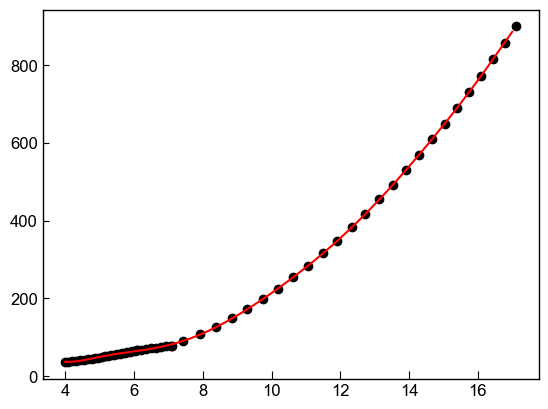

In [5]:
Petr=pd.read_excel(r'../Spreadsheets/Supporting_Information_2.xlsx', sheet_name='Petrolog_Wieser2020')
plt.plot(Petr['MgO_melt'], Petr['Ni_melt'], 'ok')
Pf = np.poly1d(np.polyfit(Petr['MgO_melt'], Petr['Ni_melt'],
                          10))
Px = np.linspace(4, 17, 101)
Py = Pf(Px)
plt.plot(Px, Py, '-r')

## Estimating Cu contents

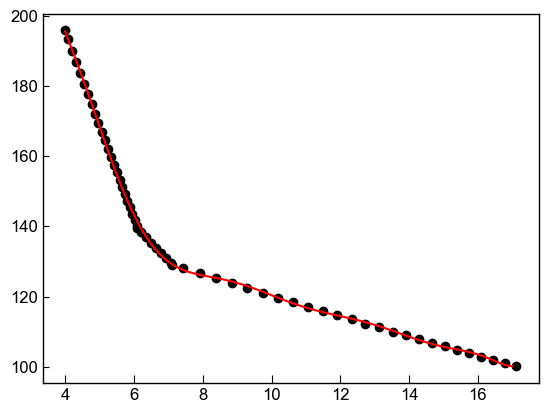

In [6]:
plt.plot(Petr['MgO_melt'], Petr['Cu_melt'], 'ok')
Pf_Cu = np.poly1d(np.polyfit(Petr['MgO_melt'], Petr['Cu_melt'],
                          10))
Px = np.linspace(4, 17, 101)
Py_Cu = Pf_Cu(Px)
plt.plot(Px, Py_Cu, '-r')

## Now get the PEC-corrected MI composition

In [7]:
df_PEC=pd.DataFrame(data={'SiO2_Liq': F8_MI['SiO2_MI_PEC EPMA'],
                         'TiO2_Liq': F8_MI['TiO2_MI_PEC EPMA'],
                         'MgO_Liq': F8_MI['MgO_MI_PEC EPMA'],
                          'FeOt_Liq': F8_MI['FeO_MI_PEC EPMA'],
                            'MnO_Liq': F8_MI['MnO_MI_PEC EPMA'],
                           'CaO_Liq': F8_MI['CaO_MI_PEC EPMA'],
                           'K2O_Liq': F8_MI['K2O_MI_PEC EPMA'],
                           'Na2O_Liq': F8_MI['Na2O_MI_PEC EPMA'],
                           'Al2O3_Liq': F8_MI['Al2O3_MI_PEC EPMA'],
                          'P2O5_Liq': F8_MI['P2O5_MI_PEC EPMA'],
                          'H2O_Liq': F8_MI['H2O'],
                          'Cu_Liq': Pf_Cu(F8_MI['MgO_MI_PEC EPMA']),
                          'Ni_Liq': Pf(F8_MI['MgO_MI_PEC EPMA']),
                        'T_K': 21.2*F8_MI['MgO_MI_PEC EPMA']+1017+273.15,
                          'P_kbar': F8_MI['SaturationP_bars_VESIcal']/1000 
                         }).reset_index(drop=True)

df_Raw_JustFeOChanged=df_Raw.copy()
df_Raw_JustFeOChanged['FeOt_Liq']=F8_MI['FeO_MI_PEC EPMA']

## Figure 5 a- b SCSS against each other. 
- First lets calculate the SCSS using the measured Ni and Cu contents and the sulfide model of Oneill

In [8]:
SCSS_Raw_ONeill_015Fe3=ss.calculate_O2021_SCSS(df=df_Raw, T_K=df_Raw['T_K'], P_kbar=df_Raw['P_kbar'], 
                                   Ni_Liq=df_Raw['Ni_Liq'], Cu_Liq=df_Raw['Cu_Liq'],
                            Fe_FeNiCu_Sulf="Calc_ONeill", Fe3Fet_Liq=0.15)

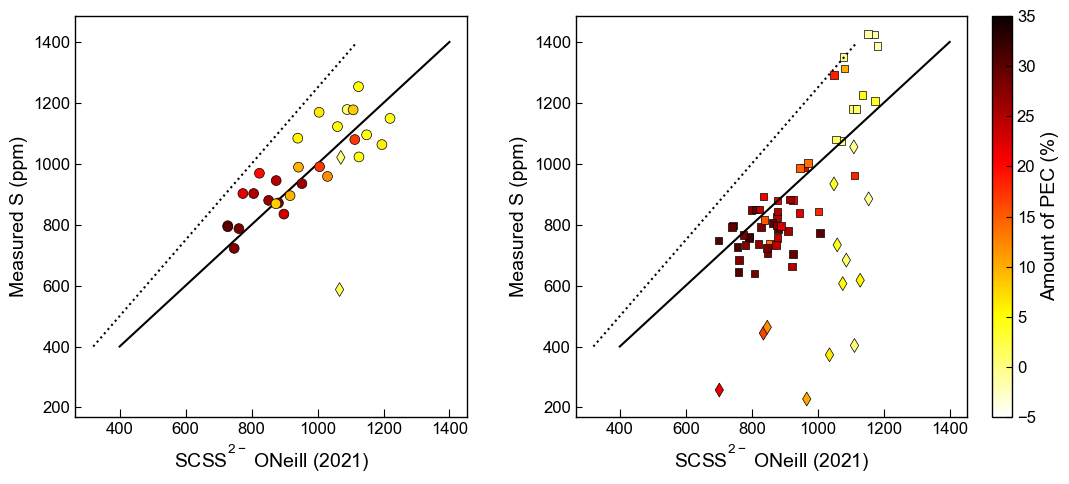

In [9]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(11,5), sharey=True)

# ax3 - Smythe, using calc sulfide composition
vmin=-5
vmax=35


s=ax3.scatter(SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Undegass&(Has_Sulf_Wieser)],
           F8_MI['S_MI EPMA (ppm)'].loc[Undegass&(Has_Sulf_Wieser)],
             marker='o', s=50, edgecolors='k', linewidths=0.5,
            c=F8_MI['Amount  PEC (%)'].loc[Undegass&(Has_Sulf_Wieser)], cmap='hot_r',
vmin = vmin, vmax = vmax, zorder=100)


s=ax3.scatter(SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Degass&(Has_Sulf_Wieser)],
           F8_MI['S_MI EPMA (ppm)'].loc[Degass&(Has_Sulf_Wieser)],
             marker='d', s=50, edgecolors='k', linewidths=0.5,
            c=F8_MI['Amount  PEC (%)'].loc[Degass&(Has_Sulf_Wieser)], cmap='hot_r',
vmin = vmin, vmax = vmax, zorder=100)



# ax4- ones without a sulfide
####################################################################

#ax4.set_title('No Visible Sulfide')
s=ax4.scatter(SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Undegass&(~Has_Sulf_Wieser)],
           F8_MI['S_MI EPMA (ppm)'].loc[Undegass&(~Has_Sulf_Wieser)],
             marker='s', s=30, edgecolors='k', linewidths=0.5,
            c=F8_MI['Amount  PEC (%)'].loc[Undegass&(~Has_Sulf_Wieser)], cmap='hot_r',
vmin = vmin, vmax = vmax, zorder=1)


s=ax4.scatter(SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Degass&(~Has_Sulf_Wieser)],
           F8_MI['S_MI EPMA (ppm)'].loc[Degass&(~Has_Sulf_Wieser)],
             marker='d', s=50, edgecolors='k', linewidths=0.5,
            c=F8_MI['Amount  PEC (%)'].loc[Degass&(~Has_Sulf_Wieser)], cmap='hot_r',
vmin = vmin, vmax = vmax, zorder=100)


S6_20_Corr=1/(1-0.2)
ax4.plot([400, 1400], [400, 1400], '-k')
ax3.plot([400, 1400], [400, 1400], '-k')
ax4.plot([400/S6_20_Corr, 1400/S6_20_Corr], [400, 1400], ':k')
ax3.plot([400/S6_20_Corr, 1400/S6_20_Corr], [400, 1400], ':k')

#ax4.plot([400/S6_10_Corr, 1400/S6_10_Corr], [400, 1400], '-r')
# ax3.annotate("Oversaturated", xy=(0.1, 0.8), xycoords="axes fraction", fontsize=12)
# ax3.annotate("Undersaturated", xy=(0.1, 0.05), xycoords="axes fraction", fontsize=12)

# ax4.annotate("Oversaturated", xy=(0.1, 0.8), xycoords="axes fraction", fontsize=12)
# ax4.annotate("Undersaturated", xy=(0.1, 0.02), xycoords="axes fraction", fontsize=12)

ax4.set_xlabel('SCSS$^{2-}$ ONeill (2021)')
ax4.set_ylabel('Measured S (ppm)')
ax3.set_xlabel('SCSS$^{2-}$ ONeill (2021)')
ax3.set_ylabel('Measured S (ppm)')
ax4.yaxis.set_tick_params(which='both', labelbottom=True)
fig.colorbar(s, ax=ax3, label='PEC-corrected MgO (wt%)')
fig.delaxes(fig.axes[2])

fig.colorbar(s, ax=ax4, label='Amount of PEC (%)')

fig.tight_layout()
fig.savefig('SCSS_Ones_With_Sulf_ONeill_PEc.png', dpi=300, transparent=True)

## Fig 5 c-d  - Difference in PEC and Raw
- For PEC-corrected, the MgO contents are sufficiently high that the ONeill model doesnt work well. Thus we used fixed sulfide compositions from Wieser et al. (2019). For raw, the MgO contents are in the range where the Model works well. Additionally, because of abundance Sulfide sequetsratoin, we expect very strange Ni and Cu contents so it wouldnt be right to use a single fixed value, regardless of how much the Ni and Cu have been stripped out. 

In [10]:
#### Calculating PEC corrected sulfides
SCSS_PEC_ONeill_FixedSulf_015Fe3=ss.calculate_O2021_SCSS(df=df_PEC, T_K=df_PEC['T_K'], P_kbar=df_PEC['P_kbar'], 
                            Fe_FeNiCu_Sulf=0.646, Fe3Fet_Liq=0.15)

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


## Now lets predict it for these melt inclusions
- Lets take the error as our MonteCarlo simulation on the amount of S in the sulfide along with a 20% error on the SCSS calcs (based on correspondnec ein Fig. 5a)
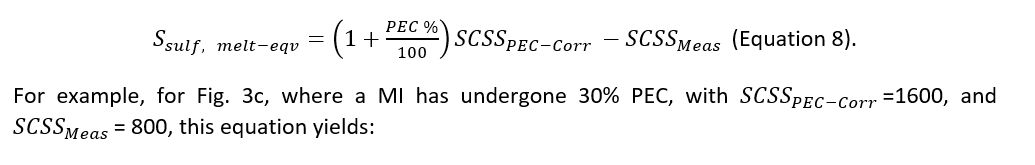

In [11]:
S_Predicted_Sulf=(1+F8_MI['Amount  PEC (%)']/100)*SCSS_PEC_ONeill_FixedSulf_015Fe3['SCSS2_ppm'] - SCSS_Raw_ONeill_015Fe3['SCSS2_ppm']

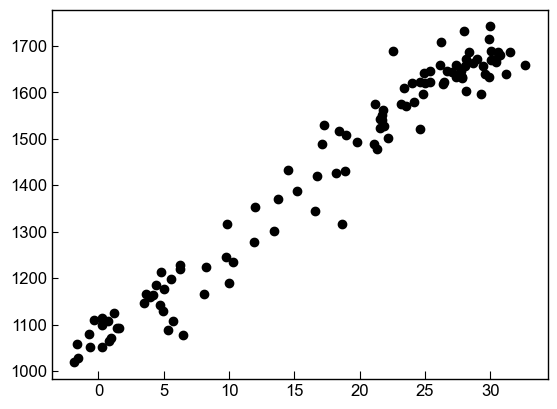

In [12]:
plt.plot(F8_MI['Amount  PEC (%)'],SCSS_PEC_ONeill_FixedSulf_015Fe3['SCSS2_ppm'], 'ok')

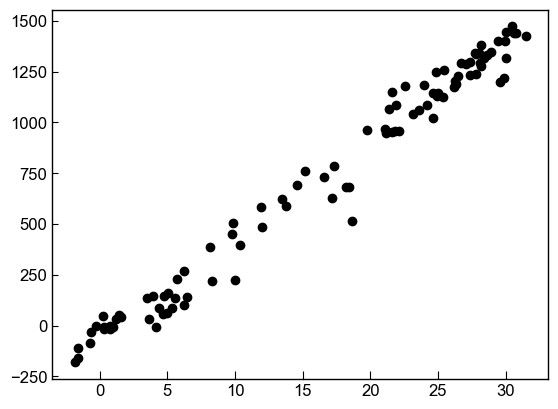

In [13]:
plt.plot(F8_MI['Amount  PEC (%)'], S_Predicted_Sulf, 'ok')


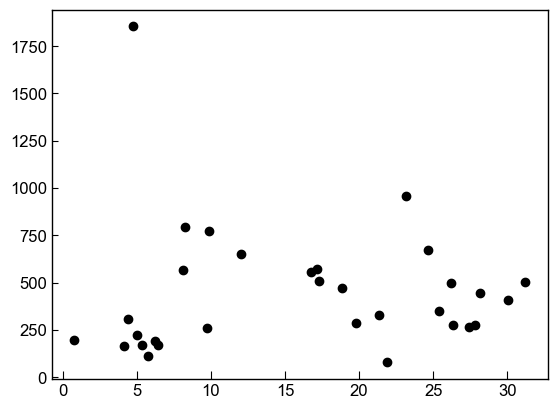

In [14]:
plt.plot(F8_MI['Amount  PEC (%)'].loc[Undegass], 
         F8_MI['ind_s_eq_melt'].loc[Undegass], 
         'ok')

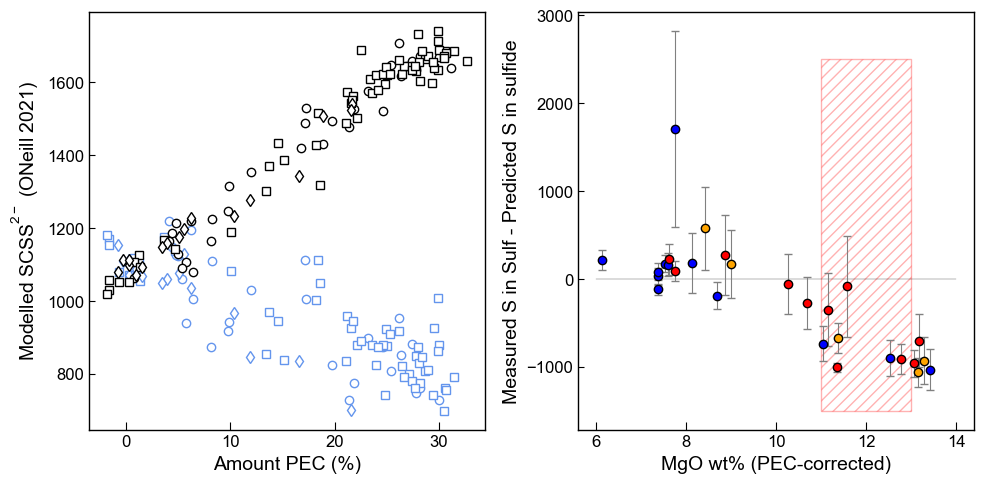

In [15]:
fig, ((ax2, ax4)) = plt.subplots(1, 2, figsize=(10,5))
Undegass&(~Has_Sulf_Wieser)

ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(Has_Sulf_Wieser)],
         SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Undegass&(Has_Sulf_Wieser)],       
         'o', mec='cornflowerblue', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(~Has_Sulf_Wieser)],
         SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Undegass&(~Has_Sulf_Wieser)],       
         's', mec='cornflowerblue', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Degass],
         SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Degass],       
         'd', mec='cornflowerblue', mfc='white')

ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(Has_Sulf_Wieser)],
         SCSS_PEC_ONeill_FixedSulf_015Fe3['SCSS2_ppm'].loc[Undegass&(Has_Sulf_Wieser)],       
         'ok', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(~Has_Sulf_Wieser)],
         SCSS_PEC_ONeill_FixedSulf_015Fe3['SCSS2_ppm'].loc[Undegass&(~Has_Sulf_Wieser)],       
         'sk', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Degass],
         SCSS_PEC_ONeill_FixedSulf_015Fe3['SCSS2_ppm'].loc[Degass],       
         'dk', mfc='white')

ax2.set_xlabel('Amount PEC (%)')
ax2.set_ylabel('Modelled SCSS$^{2-}$ (ONeill 2021)')


ax4.plot([6, 14], [0, 0], '-k', lw=0.2)
ax4.errorbar(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass], 
             F8_MI['ind_s_eq_melt'].loc[Undegass]-S_Predicted_Sulf.loc[Undegass]
             , xerr=0,
            yerr=1.2*F8_MI['std_S_eq_melt'].loc[Undegass],
            fmt='.', ms=0, ecolor='grey', elinewidth=0.8, capsize=3)  
ax4.plot(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass&LL4_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL4_MI]-S_Predicted_Sulf.loc[Undegass&LL4_MI], 'ok', mfc='blue')
ax4.plot(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass&LL7_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL7_MI]
         -S_Predicted_Sulf.loc[Undegass&LL7_MI], 'ok', mfc='orange')
ax4.plot(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass&LL8_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL8_MI]
         -S_Predicted_Sulf.loc[Undegass&LL8_MI], 'ok', mfc='red')

from matplotlib import patches
rect = patches.Rectangle((11,-1500),2,4000,
                         linewidth=1,edgecolor='r',facecolor='none', label='test',  hatch='///',
                        alpha=0.3)

ax4.set_xlabel('MgO wt% (PEC-corrected)')
ax4.set_ylabel('Measured S in Sulf - Predicted S in sulfide')

# Add the patch to the Axes
ax4.add_patch(rect)
fig.tight_layout()

fig.savefig('SCSS_Changes_PEC.png', dpi=300, transparent=True)

## Does predicted S corerelate with Cu?

(array([7., 3., 2., 5., 9., 1., 0., 0., 0., 1.]),
 array([-1064.15967442,  -786.78999509,  -509.42031576,  -232.05063644,
           45.31904289,   322.68872221,   600.05840154,   877.42808086,
         1154.79776019,  1432.16743952,  1709.53711884]),
 <BarContainer object of 10 artists>)

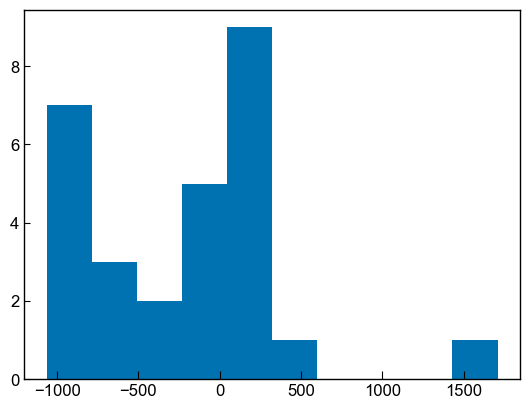

In [16]:
plt.hist(F8_MI['ind_s_eq_melt'].loc[Undegass]-S_Predicted_Sulf.loc[Undegass])

In [17]:
F8_MI.columns[F8_MI.columns.str.contains('Cu_')]

Index(['Cu_ppm_m65 LAICPMS', 'Cu_ppm_m65_Int2SE'], dtype='object')

## Lets show it doesnt really matter if we calculated sulfide instead in the grand scheme of things

In [18]:
#### Calculating PEC corrected sulfides
SCSS_PEC_ONeill_CalcSulf_015Fe3=ss.calculate_O2021_SCSS(df=df_PEC, 
T_K=df_PEC['T_K'], P_kbar=df_PEC['P_kbar'], Ni_Liq=df_PEC['Ni_Liq'],
Cu_Liq=df_PEC['Cu_Liq'],
Fe_FeNiCu_Sulf="Calc_ONeill", Fe3Fet_Liq=0.15)

### Calculating amount of S we expect in the sulfide
S_Predicted_CalcSulf=( (SCSS_PEC_ONeill_CalcSulf_015Fe3['SCSS2_ppm'])*F8_MI['Amount  PEC (%)']/100
+ (SCSS_PEC_ONeill_CalcSulf_015Fe3['SCSS2_ppm']-SCSS_Raw_ONeill_015Fe3['SCSS2_ppm']))


In [19]:
SCSS_PEC_ONeill_CalcSulf_015Fe3

SCSS2_ppm       LnS  Ln_a_FeO  Ln_a_FeS    DeltaG  LnCS2_calc  \
0    1242.691068  7.125035 -2.290561 -0.452955  7.843453   -2.556024   
1    1240.956725  7.123638 -2.287678 -0.452814  7.827176   -2.538403   
2    1116.822112  7.018243 -2.281057 -0.455956  8.062317   -2.869176   
3    1133.391947  7.032970 -2.278422 -0.452183  8.043094   -2.836363   
4    1135.936308  7.035213 -2.218596 -0.442011  8.009916   -2.751288   
..           ...       ...       ...       ...       ...         ...   
107  1390.733067  7.237586 -2.337621 -0.605270  7.301704   -1.796469   
108          NaN       NaN -2.352453 -0.721227       NaN   -1.452482   
109          NaN       NaN -2.303159 -0.539747       NaN   -1.999740   
110          NaN       NaN -2.318226 -0.617493       NaN   -1.764552   
111          NaN       NaN -2.365678 -0.755912       NaN   -1.390591   

     SiO2_Liq  TiO2_Liq  MgO_Liq  FeOt_Liq  ...  Na2O_Liq  Al2O3_Liq  \
0      50.793     2.550    7.432    11.337  ...     2.303     13.523   
1      51.117     2.512    7.526    11.434  ...     2.435     13.435   
2      51.649     2.758    6.020    11.338  ...     2.435     13.747   
3      51.918     2.789    6.143    11.343  ...     2.583     13.903   
4      51.702     2.754    6.351    11.692  ...     2.822     13.730   
..        ...       ...      ...       ...  ...       ...        ...   
107    49.922     2.187   11.154    11.336  ...     2.076     11.701   
108    49.228     2.090   13.143    11.334  ...     2.040     11.221   
109    49.516     2.649    9.810    11.347  ...     2.210     12.298   
110    50.027     2.032   11.390    11.336  ...     2.389     11.838   
111    49.730     1.869   13.700    11.336  ...     2.089     11.046   

     P2O5_Liq  H2O_Liq      Cu_Liq      Ni_Liq        T_K  P_kbar  Fe3Fet_Liq  \
0           0      0.5  127.584556   90.479446  1447.7084    0.64        0.15   
1           0      0.5  127.239780   93.270268  1449.7012    0.37        0.15   
2           0      0.5  142.859005   63.846947  1417.7740    0.42        0.15   
3           0      0.5  140.539973   65.424220  1420.3816    0.47        0.15   
4           0      0.5  137.092398   68.233975  1424.7912    0.44        0.15   
..        ...      ...         ...         ...        ...     ...         ...   
107         0      0.5  116.427222  290.717349  1526.6148    0.06        0.15   
108         0      NaN  111.483105  455.321851  1568.7816     NaN        0.15   
109         0      NaN  121.114348  202.045442  1498.1220     NaN        0.15   
110         0      NaN  115.807140  307.929894  1531.6180     NaN        0.15   
111         0      NaN  109.603621  509.388326  1580.5900     NaN        0.15   

     Fe_FeNiCu_Sulf_calc  
0               0.688205  
1               0.688678  
2               0.686477  
3               0.688409  
4               0.697293  
..                   ...  
107             0.590214  
108             0.525290  
109             0.630414  
110             0.582780  
111             0.507197  

[112 rows x 23 columns]

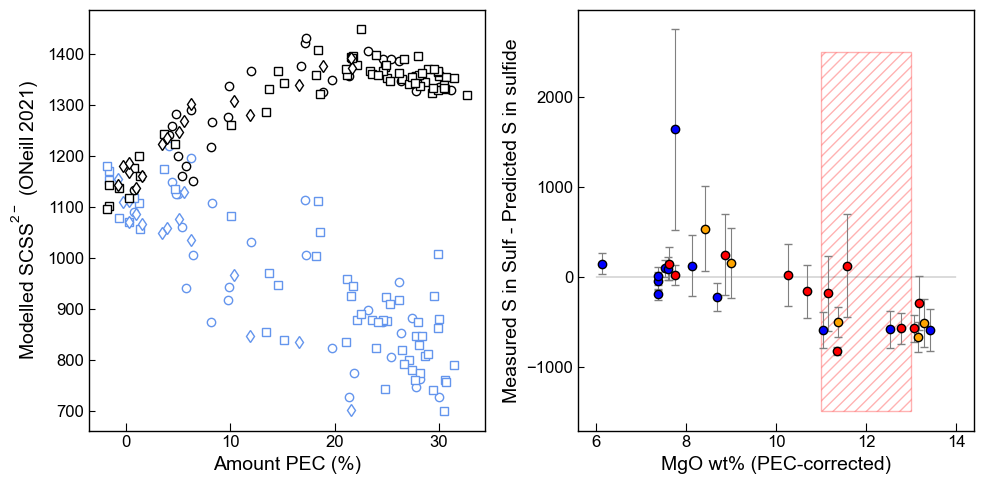

In [20]:


fig, ((ax2, ax4)) = plt.subplots(1, 2, figsize=(10,5))
Undegass&(~Has_Sulf_Wieser)

ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(Has_Sulf_Wieser)],
         SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Undegass&(Has_Sulf_Wieser)],       
         'o', mec='cornflowerblue', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(~Has_Sulf_Wieser)],
         SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Undegass&(~Has_Sulf_Wieser)],       
         's', mec='cornflowerblue', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Degass],
         SCSS_Raw_ONeill_015Fe3['SCSS2_ppm'].loc[Degass],       
         'd', mec='cornflowerblue', mfc='white')

ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(Has_Sulf_Wieser)],
         SCSS_PEC_ONeill_CalcSulf_015Fe3['SCSS2_ppm'].loc[Undegass&(Has_Sulf_Wieser)],       
         'ok', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Undegass&(~Has_Sulf_Wieser)],
         SCSS_PEC_ONeill_CalcSulf_015Fe3['SCSS2_ppm'].loc[Undegass&(~Has_Sulf_Wieser)],       
         'sk', mfc='white')
ax2.plot(F8_MI['Amount  PEC (%)'].loc[Degass],
         SCSS_PEC_ONeill_CalcSulf_015Fe3['SCSS2_ppm'].loc[Degass],       
         'dk', mfc='white')

ax2.set_xlabel('Amount PEC (%)')
ax2.set_ylabel('Modelled SCSS$^{2-}$ (ONeill 2021)')


ax4.plot([6, 14], [0, 0], '-k', lw=0.2)
ax4.errorbar(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass], 
             F8_MI['ind_s_eq_melt'].loc[Undegass]-S_Predicted_CalcSulf.loc[Undegass]
             , xerr=0,
            yerr=1.2*F8_MI['std_S_eq_melt'].loc[Undegass],
            fmt='.', ms=0, ecolor='grey', elinewidth=0.8, capsize=3)  




ax4.plot(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass&LL4_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL4_MI]-S_Predicted_CalcSulf.loc[Undegass&LL4_MI], 'ok', mfc='blue')
ax4.plot(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass&LL7_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL7_MI]
         -S_Predicted_CalcSulf.loc[Undegass&LL7_MI], 'ok', mfc='orange')
ax4.plot(F8_MI['MgO_MI_PEC EPMA'].loc[Undegass&LL8_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL8_MI]
         -S_Predicted_CalcSulf.loc[Undegass&LL8_MI], 'ok', mfc='red')

from matplotlib import patches
rect = patches.Rectangle((11,-1500),2,4000,
                         linewidth=1,edgecolor='r',facecolor='none', label='test',  hatch='///',
                        alpha=0.3)

ax4.set_xlabel('MgO wt% (PEC-corrected)')
ax4.set_ylabel('Measured S in Sulf - Predicted S in sulfide')

# Add the patch to the Axes
ax4.add_patch(rect)
fig.tight_layout()

fig.savefig('SCSS_Changes_PEC_CalcInstead.png', dpi=300)

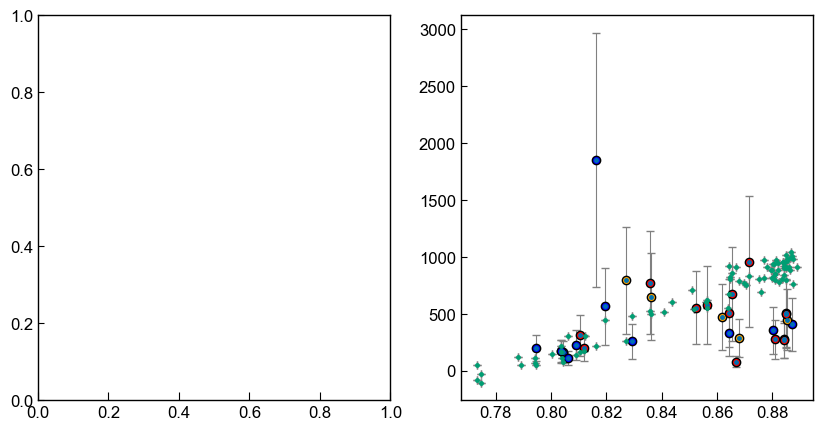

In [21]:
fig, ((ax2, ax4)) = plt.subplots(1, 2, figsize=(10,5))

ax4.errorbar(F8_MI['Mg# Min'].loc[Undegass], 
             F8_MI['ind_s_eq_melt'].loc[Undegass]
             , xerr=0,
            yerr=1.2*F8_MI['std_S_eq_melt'].loc[Undegass],
            fmt='.', ms=5, ecolor='grey', elinewidth=0.8, capsize=3)  


ax4.errorbar(F8_MI['Mg# Min'].loc[Undegass], 
             S_Predicted_CalcSulf.loc[Undegass]
             , xerr=0,
            yerr=0,
            fmt='.', ms=5, ecolor='grey', elinewidth=0.8, capsize=3)  



ax4.plot(F8_MI['Mg# Min'].loc[Undegass&LL4_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL4_MI], 'ok', mfc='blue')
ax4.plot(F8_MI['Mg# Min'].loc[Undegass&LL7_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL7_MI]
         , 'ok', mfc='orange')
ax4.plot(F8_MI['Mg# Min'].loc[Undegass&LL8_MI], 
        F8_MI['ind_s_eq_melt'].loc[Undegass&LL8_MI]
         , 'ok', mfc='red')


In [22]:
HighFoones=F8_MI.loc[(F8_MI['Mg# Min']>0.88) & (F8_MI['ind_s_eq_melt']>0)]
HighFoones

Comment Sample number  \
56   LL8_243_b           LL8   
67     LL8_426           LL8   
69   LL8_400_b           LL8   
70   LL8_400_a           LL8   
79       LL4_3           LL4   
80      LL4_12           LL4   
98   LL7_111_B           LL7   
103    LL7_282           LL7   

      EPMA data for glass phase of melt inclusions (Uncorrected for PEC) (------->)  \
56                                                 NaN                                
67                                                 NaN                                
69                                                 NaN                                
70                                                 NaN                                
79                                                 NaN                                
80                                                 NaN                                
98                                                 NaN                                
103                                                NaN                                

     Na2O_MI EPMA  Al2O3_MI EPMA  P2O5_MI EPMA  CaO_MI EPMA  K2O_MI EPMA  \
56         2.8267        15.6932        0.2551      12.4434       0.4106   
67         2.7017        14.1913        0.2471      11.9179       0.4951   
69         2.5920        13.4239        0.3214      12.1460       0.4201   
70         2.7252        14.4115        0.3428      12.0020       0.5237   
79         2.7123        14.1951        0.2779      12.2278       0.4162   
80         2.8880        14.7528        0.2729      12.1832       0.4076   
98         2.7812        14.7406        0.2787      11.8886       0.3931   
103        2.6346        14.5514        0.2655      12.1453       0.3820   

     TiO2_MI EPMA  SiO2_MI EPMA  ...  Unnamed: 194  Unnamed: 195  \
56         2.5360       52.2261  ...      0.754993      0.762137   
67         2.6857       52.4191  ...      0.789739      0.791452   
69         2.6159       51.3023  ...      0.802190      0.792267   
70         2.7735       51.7024  ...      0.784800      0.785053   
79         2.9353       51.1449  ...      0.802499      0.797321   
80         2.4707       52.1452  ...      0.767910      0.768935   
98         2.4506       52.1212  ...      0.780972      0.782473   
103        2.5101       51.9385  ...      0.780105      0.780214   

     Density_g_per_cm3  Uncertainty_g_per_cm3  Unnamed: 198   Filename  \
56            2.628303               0.041221      0.015683  LL8_243_b   
67            2.638100               0.041942      0.015898    LL8_426   
69            2.642459               0.042761      0.016182  LL8_400_b   
70            2.647401               0.042046      0.015882  LL8_400_a   
79            2.637354               0.043357      0.016440      LL4_3   
80            2.628047               0.042682      0.016241     LL4_12   
98            2.634550               0.042756      0.016229  LL7_111_B   
103           2.638829               0.042778      0.016211    LL7_282   

     std_S_eq_melt  med_S_eq_melt  mean_S_eq_melt  ind_s_eq_melt  
56      247.324022     513.253892      511.147515     502.953009  
67      142.529734     272.550370      275.722617     274.247705  
69      252.257888     482.061943      498.706162     499.699319  
70      129.435957     268.110548      271.171808     267.240574  
79      171.920874     357.066183      354.182827     352.687131  
80      194.453726     395.592220      401.348648     408.705362  
98      137.164802     274.008591      278.519054     274.175283  
103     222.590290     428.989304      446.696516     446.494288  

[8 rows x 204 columns]

In [26]:
F8_MI.loc[ (F8_MI['ind_s_eq_melt']>1000)]

Comment Sample number  \
99  LL4_13           LL4   

     EPMA data for glass phase of melt inclusions (Uncorrected for PEC) (------->)  \
99                                                NaN                                

    Na2O_MI EPMA  Al2O3_MI EPMA  P2O5_MI EPMA  CaO_MI EPMA  K2O_MI EPMA  \
99        2.7155        13.9004        0.1687       10.561       0.5081   

    TiO2_MI EPMA  SiO2_MI EPMA  ...  Unnamed: 194  Unnamed: 195  \
99        3.0447       49.5825  ...      0.974218      0.954472   

    Density_g_per_cm3  Uncertainty_g_per_cm3  Unnamed: 198  Filename  \
99            2.71549               0.042414      0.015619    LL4_13   

    std_S_eq_melt  med_S_eq_melt  mean_S_eq_melt  ind_s_eq_melt  
99     930.540483    1886.441967     1881.317582    1854.430497  

[1 rows x 204 columns]

In [24]:
HighFoones['Vol_Prop_Sulf']

56     0.094965
67     0.051975
69     0.094859
70     0.050826
79     0.066822
80     0.077162
98     0.051891
103    0.084642
Name: Vol_Prop_Sulf, dtype: float64

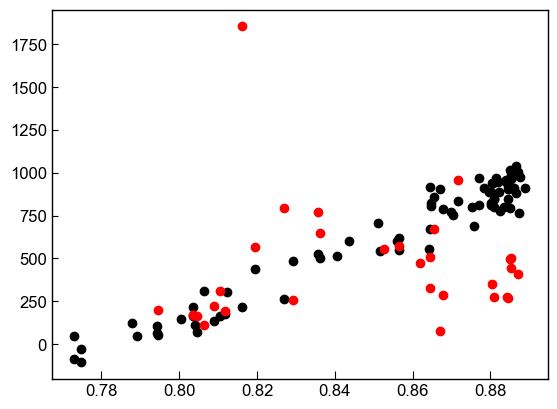

In [25]:
plt.plot(
         F8_MI['Mg# Min'].loc[Undegass],
    S_Predicted_CalcSulf.loc[Undegass], 'ok')

plt.plot(
         F8_MI['Mg# Min'].loc[Undegass],
     F8_MI['ind_s_eq_melt'].loc[Undegass], 'or')

